# Tutorial: a workflow of uncertainty characterisation, aggregation, and propagation using `pyuncertainnumber`

# setup

## Installation

Install the [pyuncertainnumber](https://github.com/leslieDLcy/PyUncertainNumber) library from [PyPI](https://pypi.org/project/pyuncertainnumber/).

```shell
pip install pyuncertainnumber
```

::: {.callout-important}
A virtual enviroment is recommended for installation.

Follow the [instructions](https://pyuncertainnumber.readthedocs.io/en/latest/guides/installation.html) for additional details to install `pyuncertainnumber`.
:::

In [1]:
from pyuncertainnumber import UN
import pyuncertainnumber as pun
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set up a global plotting style
plt.rcParams.update({
        "font.size": 11,
        "text.usetex": True,
        "font.family": "serif",
        "legend.fontsize": 'small',
        })

# Characterisation

## Canonical specification

There are two ways to specify an uncertain number when you have enough information: a **verbose** way to specify all the fields and a **shortcut** way to focus on computational purposes. Later sections will show many situations where you have only partial information.

::: {.callout-tip title="natural language support when specifying intervals" collapse="true"}

- When specifying intervals, whether directly for an interval-type `uncertain number` or interval-valued shape parameters in a p-box, one can use natual language such as "about 3", "around 3" or intuitive format '[3 +- 10%]'. 

- Also, one can explicitly call using argument *essence='pbox'* or implicitly call distribution with interval parameters

- There are many more fields avilable to portrait the modelled uncertain quantify, such as "provenence", "justification", etc.
:::

In [3]:
# verbose specification of uncertain numbers
# interval-type uncertain number
a = UN(name='elas_modulus', 
                 symbol='E', 
                 units='Pa', 
                 essence='interval', 
                 intervals=[2,3]
                )

# distribution-type uncertain number
b = UN(
    name='elas_modulus', 
    symbol='E', 
    units='Pa', 
    essence='distribution', 
    distribution_parameters=['gaussian', (6, 2)])

# pbox-type uncertain number
c = UN(
    name='elas_modulus', 
    symbol='E', 
    units='Pa', 
    essence='pbox', 
    distribution_parameters=['gaussian', ([0,12],[1,4])])

# dempster-shafer-type uncertain number
d = UN(
    name='elas_modulus', 
    symbol='E', 
    units='Pa', 
    essence='dempster_shafer', 
    intervals=[[1,5], [3,6]], 
    masses=[0.5, 0.5]
    )

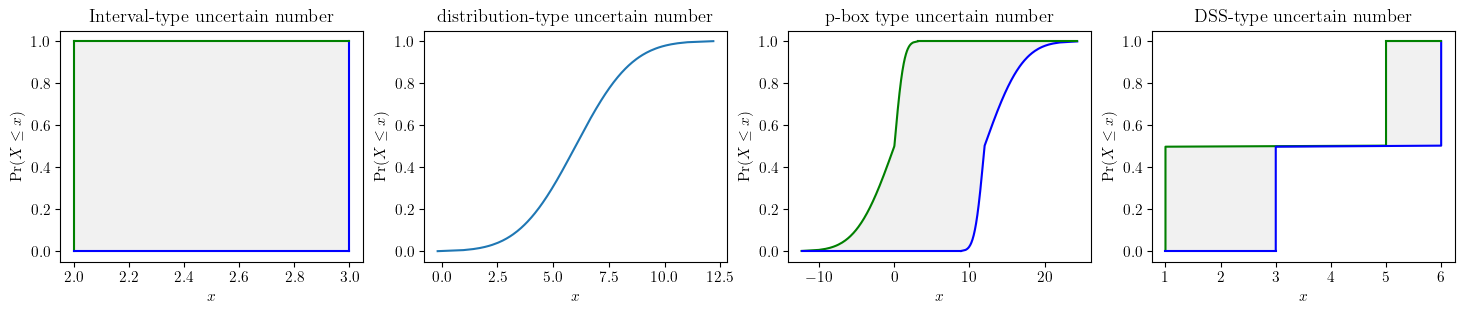

In [4]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(18, 3))
a.plot(ax=ax1, title='Interval-type uncertain number')
b.plot(ax=ax2, title='distribution-type uncertain number')
c.plot(ax=ax3, title='p-box type uncertain number', nuance='curve')
d.plot(ax=ax4, title='DSS-type uncertain number', nuance='curve')
plt.show()

::: {.callout-important title="shortcuts" collapse="true"}

Alternatively, **shortcuts** existed to instantiate uncertain numbers are also possible when one wants to quickly get on with calculations.

:::

In [5]:
# shortcuts to instantiate uncertain numbers
a = pun.I(2, 3)
b = pun.D('gaussian', (6, 2))
c = pun.normal([0,12], [1,4])
d = pun.DSS([[1,5], [3,6]], [0.5, 0.5])

## Known constraints

Often there is only partial empirical information (*e.g. statistical information*) pertaining some variables. A faithful characterisation entails that all of the available statistical information should be utilised but without introducing any extra assumptions beyond what are empirically justified.

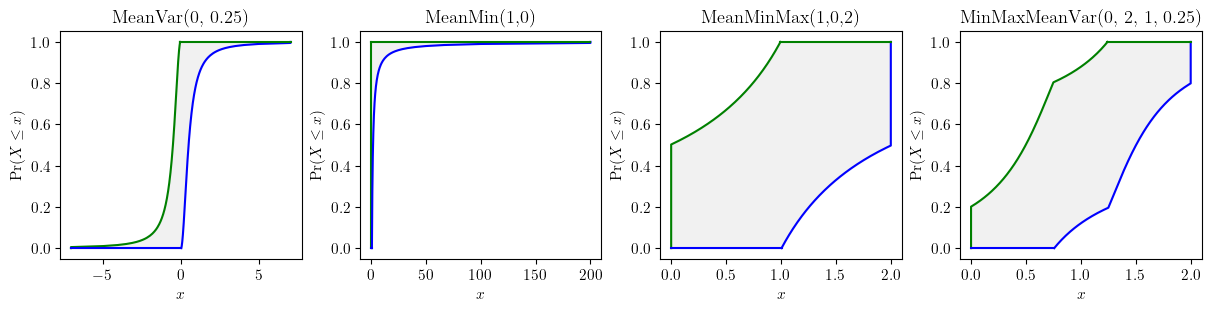

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 3), layout="constrained")
pun.known_constraints(mean=0, var=0.25).plot(title='MeanVar(0, 0.25)', ax=axes[0], nuance='curve')
pun.known_constraints(minimum=0, mean=1).plot(title='MeanMin(1,0)', ax=axes[1], nuance='curve')
pun.known_constraints(minimum=0, mean=1, maximum=2).plot(title='MeanMinMax(1,0,2)', ax=axes[2], nuance='curve')
pun.known_constraints(minimum=0, mean=1, var=0.25, maximum=2).plot(title='MinMaxMeanVar(0, 2, 1, 0.25)', ax=axes[3], nuance='curve')
plt.show()

## Characterisation from empirical measurements


Empirical data rarely come in perfect forms, especially for in situ measurements. Practical computations frequently deal with poor measurements. Data uncertainty mainly consists of sampling uncertainty and measurement uncertainty. Both parametric and nonparametric estimators are provided to characterise data uncertainties. 

In [7]:
from pyuncertainnumber import pba
import scipy.stats as sps

In [8]:
precise_sample = sps.expon(scale=1/0.4).rvs(15)
imprecise_data = pba.I(lo = precise_sample - 1.4, hi=precise_sample + 1.4)

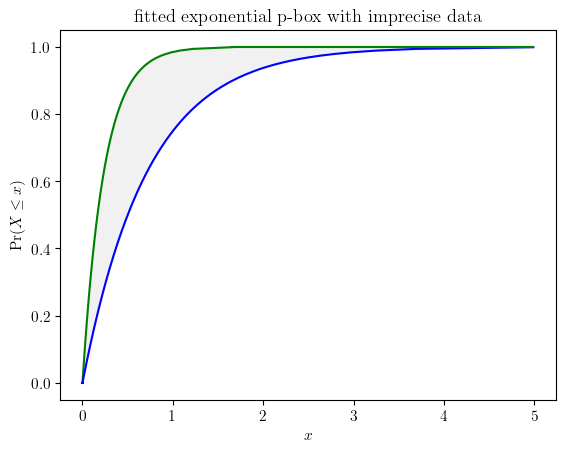

In [9]:
# parametric estimator
fn = pun.fit('mom', family='exponential', data=imprecise_data)
fn.display(title='fitted exponential p-box with imprecise data', nuance='curve')

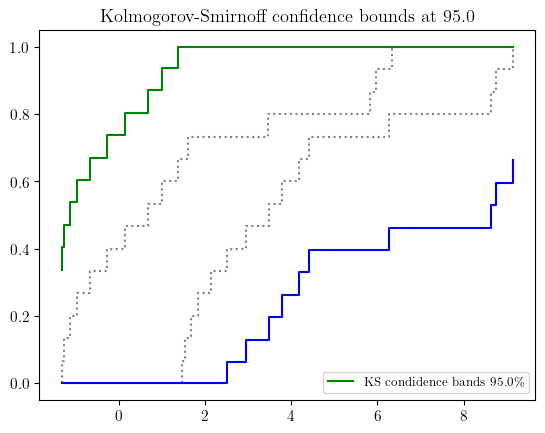

In [10]:
# nonparametric estimator with the KS bounds 
b_l, b_r = pun.KS_bounds(imprecise_data, alpha=0.025, display=True)

# Aggregation of various sources of information, expert elicitation, or evidence

In [11]:
from pyuncertainnumber import stochastic_mixture, envelope
from pyuncertainnumber.pba.ecdf import pl_ecdf_bounding_bundles
from pyuncertainnumber.pba.dss import plot_DS_structure_with_labels

## expert elicitation is represented as probability distribution

In [12]:
a_d = pun.D('gaussian', (-5, 2))
b_d = pun.D('normal', (1.5, 3.))
c_d = pun.D('uniform', (1, 12))
d_d = pun.D('gaussian', (10, 1.5))
fixed_value=0
p_env = envelope(a_d, b_d, c_d, d_d)

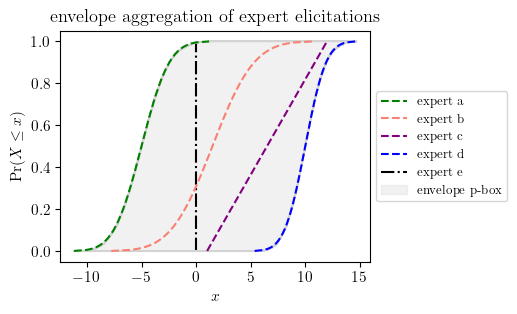

In [13]:
fig, ax = plt.subplots(figsize=(4, 3))
a_d.plot(ax=ax, label='expert a', color='green', ls='--', zorder=100)
b_d.plot(ax=ax, color='salmon', zorder=50, ls='--', label='expert b')
c_d.plot(ax=ax, label='expert c', color='purple', ls='--', zorder=100)
d_d.plot(ax=ax, label='expert d', color='blue', ls='--', zorder=100)
ax.vlines(fixed_value, ymin=0, ymax=1, color='black', linestyle='dashdot', label='expert e')
p_env.plot(ax=ax,  bound_colors=['lightgray', 'lightgray'], fill_color='lightgray', label='envelope p-box')
ax.set_title("envelope aggregation of expert elicitations")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

## expert opinion is represented as intervals


In [14]:
a = pun.I(1,5)
b = pun.I(3,6)
c = pun.I(2,3)
d = pun.I(2,9)

In [15]:
dss = stochastic_mixture(a,b,c,d)

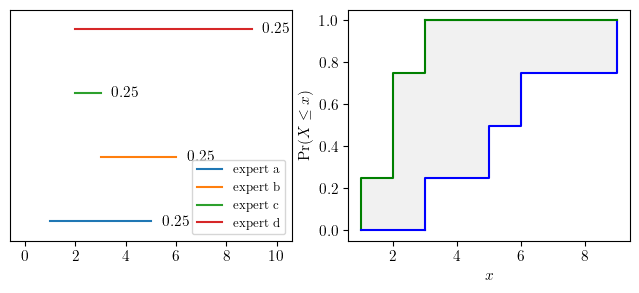

In [16]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 3))                          
ax0 = plot_DS_structure_with_labels([a,b,c,d], masses=[0.25, 0.25, 0.25, 0.25], offset=1.5, ax=ax0)
dss.plot(ax=ax1)
plt.show()

# Uncertainty propagation

## arithmetic of uncertain number

[Probability bounds anlaysis](https://en.wikipedia.org/wiki/Probability_bounds_analysis) combines both interval analysis and probability theory, allowing
rigorous bounds of (arithmetic) functions of random variables to be computed even with partial information.

In [17]:
X = pun.uniform(1, [2,3])
Y = X

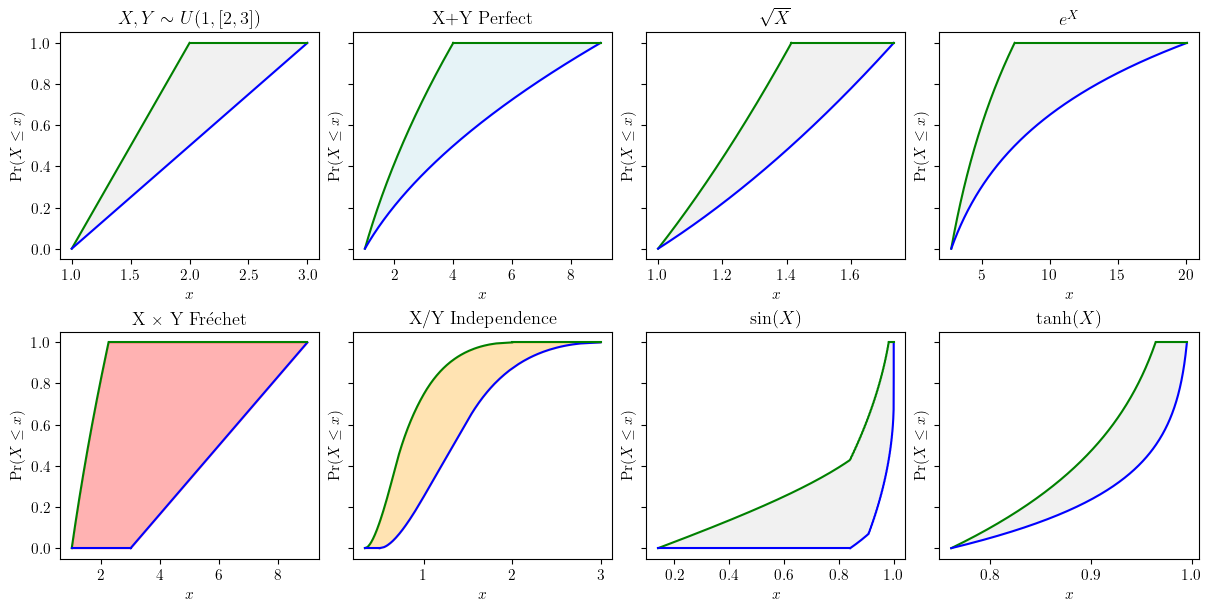

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(12, 6), layout="constrained")

X.plot(ax=axes[0, 0], title='$X, Y \sim U(1, [2,3])$', nuance='curve')

# add Perfect
Z_add_p = X.mul(Y, dependency='p')
Z_add_p.plot(ax=axes[0, 1], title='X+Y Perfect', fill_color='lightblue', nuance='curve')

# mul Opposite
Z_mul_o = X.mul(Y, dependency='o')
Z_mul_f = X.mul(Y, dependency='f')
Z_mul_f.plot(ax=axes[1, 0], title="X × Y Fréchet", fill_color='red', nuance='curve')

# div Independence
Z_div_i = X.div(Y, dependency='i')
Z_div_f = X.div(Y, dependency='f')
Z_div_i.plot(ax=axes[1, 1], title='X/Y Independence', fill_color='orange', nuance='curve')

### unary ops ###
# squared
(X**0.5).plot(ax=axes[0,2], title='$\sqrt{X}$', nuance='curve')

# exponential
X.exp().plot(ax=axes[0,3], title='$e^{X}$', nuance='curve')

# sin
X.sin().plot(ax=axes[1,2], title='$\sin(X)$', nuance='curve')

# tanh
X.tanh().plot(ax=axes[1,3], title=r"$\tanh (X)$", nuance='curve')

plt.show()


::: {.callout-note title="beyond arithmetic" collapse="true"}

Beyond arithmetics, various advanced methods have been proposed for propagation of diﬀerent types of uncertainties, intrusive or nonintrusive, depending on the characteristic of the performance function such as linearity, monotonicity, or the accessibility to gradients. See additional details in the [documentation](https://pyuncertainnumber.readthedocs.io/en/latest/guides/up.html).

A high-level API has been provided for delpoying these various methods under various uncertainty situations with a consistent signature.
:::

## generic propagation of uncertain numbers

In [19]:
from pyuncertainnumber import Propagation

In [20]:
a = pun.I(2, 3)
b = pun.normal(10, 1)
c = pun.normal([6, 9], 3)

In [21]:
# specify a response function
def foo(x):  
    if isinstance(x, np.ndarray):
        if x.ndim == 1:
            x = x[None, :]
        return x[:, 0] ** 3 + x[:, 1] + x[:, 2]# vectorised signature
    else:
        return x[0] ** 3 + x[1] + x[2]  # iterable signature

In [22]:
# intrusive call signature as drop-in replacements
response = foo([a, b, c])

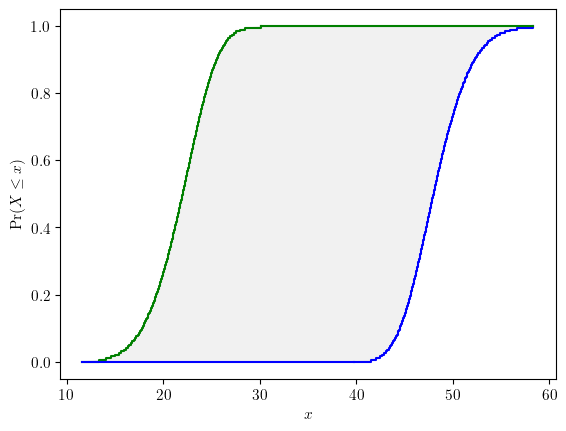

In [23]:
response.display()

In [24]:
# a generic call signature
p = Propagation(vars=[a, b, c], func=foo, method='slicing', interval_strategy='subinterval')
response = p.run(n_slices=50, n_sub=2, style='endpoints')

INFO: mixed uncertainty propagation


::: {.callout-warning title="exponential increase computation burden" collapse="true"}

The computational cost increases exponentially with the number of input variables and the number of slices. Be cautious with the choice of number of slices `n_slices` given the number of input variables of the response function.

:::

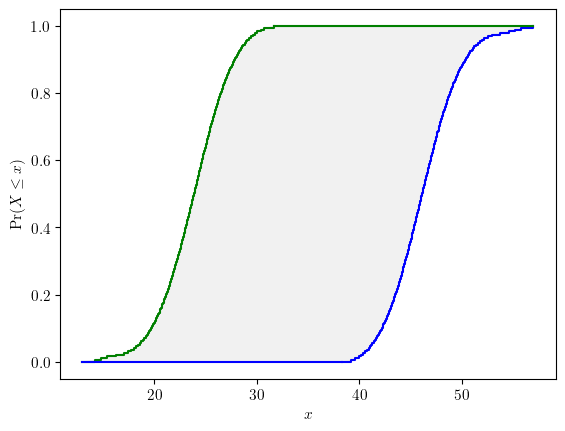

In [25]:
response.display()